In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotnine
from plotnine import ggplot, geom_histogram, aes

PATH_TO_DATA = '../data/'
PATH_TO_OUTPUT_DATA = '../output-data/'
PATH_TO_MODEL_DATA = '../model-data/'
PATH_TO_VIS_DATA = '../visualization-data/'

In [2]:
# imports
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import brier_score_loss, confusion_matrix, \
    roc_auc_score, roc_curve, auc, average_precision_score, precision_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
MLB_DF = pd.read_csv(PATH_TO_OUTPUT_DATA + 'MLB_INPUT.csv')
MLB_DF['home_ISO'] = MLB_DF['home_SLG'] - MLB_DF['home_AVG']
MLB_DF['away_ISO'] = MLB_DF['away_SLG'] - MLB_DF['away_AVG']
MLB_DF['ISO_difference'] = MLB_DF['home_ISO'] - MLB_DF['away_ISO']
MLB_DF['ISO_difference_PCT'] = (MLB_DF['home_ISO'] - MLB_DF['away_ISO'])/ MLB_DF['home_ISO']*100

In [4]:
cutoff = 2015

In [5]:
def create_features(data, pct = True):
    features = data.drop(labels = 
                       ['dt', 'Y', 'M', 'D', 'away_team', 
                        'home_team', 'away_pitcher_id', 'home_pitcher_id',
                       'date'],
                      axis = 1)
    features['rest_difference'] = features['home_rest'] - features['away_rest']
    features['ELO_difference_PCT'] = features['ELO_difference']/features['home_ELO']*100
    if (pct == True):
        PCT_DIFF = features[[i for i in list(features) if 'PCT' in i] + ['rest_difference', 'outcome']]
        PCT_DIFF_features = [i for i in list(features) if 'PCT' in i] + ['rest_difference']
        PCT_DIFF.drop(labels = ['AVG_difference_PCT', 'SLG_difference_PCT', 
                            'BAA_difference_PCT', 'IP_Start_difference_PCT', 'ERA_difference_PCT'],
                 axis = 1, inplace = True)
        PCT_DIFF_features = [i for i in list(PCT_DIFF) if (i != 'outcome')]
        return PCT_DIFF[PCT_DIFF_features], PCT_DIFF['outcome']
    else:
        DIFF = features[[i for i in list(features) if 
                         (('difference' in i) and ('PCT' not in i))] + ['outcome']]
        DIFF.drop(labels = ['AVG_difference', 'SLG_difference', 'BAA_difference', 'IP_Start_difference',
                           'ERA_difference'],
                 axis = 1, inplace = True)
        DIFF_features = [i for i in list(DIFF) if (i != 'outcome')]
        return DIFF[DIFF_features], DIFF['outcome']
    
# splits season into 3/4 for train, 1/4 for test
def seasonal_train_test_split(X, Y):
    test_train_cutoff = int(len(X)*.75)
    x_train = X[0:test_train_cutoff]
    x_test = X[test_train_cutoff:]
    y_train = Y[0:test_train_cutoff]
    y_test = Y[test_train_cutoff:]
    
    return x_train, x_test, y_train, y_test

# Generate 
def create_yearly_samples(MLB_DF = MLB_DF[MLB_DF.Y > cutoff], scaling = False):
    if (scaling == True):
        pd.options.mode.chained_assignment = None
    sclr = StandardScaler()
    years = list(set(MLB_DF.Y))
    YEARLY_DATA = {}
    for i in years:
        YEARLY_MLB = create_features(MLB_DF[MLB_DF.Y == i])
#         x_train, x_test, y_train, y_test = seasonal_train_test_split(YEARLY_MLB[0], YEARLY_MLB[1])
        x = YEARLY_MLB[0]
        if (scaling == True):
            x = sclr.fit_transform(x)
         
        YEARLY_DATA[i] = {
            'x': x,
            'y': YEARLY_MLB[1],
#             'y_train': y_train,
#             'y_test': y_test
        }
    return YEARLY_DATA

In [6]:
# Create our yearly df
MLB_FINAL_DATA_SCALED = create_yearly_samples(scaling = True)
MLB_FINAL_DATA_UNSCALED = create_yearly_samples(scaling = False)

In [217]:
print(len(MLB_DF))
create_features(MLB_DF[MLB_DF.Y <= cutoff], False)[0].shape

46128


(36417, 9)

In [7]:
# Create testing DF
SCALED_ML_RESULTS = pd.DataFrame(sorted(set(MLB_DF[MLB_DF.Y > cutoff]['Y']))).rename(
    {0: 'Y'}, axis = 1).set_index('Y')
SCALED_ML_RESULTS['LogitLasso'] = 0
SCALED_ML_RESULTS['LogitRidge'] = 0
SCALED_ML_RESULTS['LogitElasticNet'] = 0
SCALED_ML_RESULTS['SVC_C10'] = 0
SCALED_ML_RESULTS['SVC_C1'] = 0
SCALED_ML_RESULTS['SVC_C0.01'] = 0
SCALED_ML_RESULTS['KNN_20_Uniform'] = 0
SCALED_ML_RESULTS['KNN_10_Uniform'] = 0
SCALED_ML_RESULTS['KNN_10_Distance'] = 0
SCALED_ML_RESULTS

,LogitLasso,LogitRidge,LogitElasticNet,SVC_C10,SVC_C1,SVC_C0.01,KNN_20_Uniform,KNN_10_Uniform,KNN_10_Distance
Y,,,,,,,,,
2016,0,0,0,0,0,0,0,0,0
2017,0,0,0,0,0,0,0,0,0
2018,0,0,0,0,0,0,0,0,0
2019,0,0,0,0,0,0,0,0,0


In [8]:
# Create testing DF
UNSCALED_ML_RESULTS = pd.DataFrame(sorted(set(MLB_DF[MLB_DF.Y > cutoff]['Y']))).rename(
    {0: 'Y'}, axis = 1).set_index('Y')
UNSCALED_ML_RESULTS['LogitLasso'] = 0
UNSCALED_ML_RESULTS['LogitRidge'] = 0
UNSCALED_ML_RESULTS['LogitElasticNet'] = 0
UNSCALED_ML_RESULTS['DecisionTree'] = 0
UNSCALED_ML_RESULTS['RF'] = 0
UNSCALED_ML_RESULTS['SGD'] = 0
UNSCALED_ML_RESULTS['XGBoost'] = 0
UNSCALED_ML_RESULTS

,LogitLasso,LogitRidge,LogitElasticNet,DecisionTree,RF,SGD,XGBoost
Y,,,,,,,
2016,0,0,0,0,0,0,0
2017,0,0,0,0,0,0,0
2018,0,0,0,0,0,0,0
2019,0,0,0,0,0,0,0


In [9]:
# Create testing DF
UNSCALED_ML_RESULTS_MONTH = pd.DataFrame(
    sorted(set(MLB_DF[MLB_DF.Y == 2019]['M']))).rename(
    {0: 'M'}, axis = 1).set_index('M')
UNSCALED_ML_RESULTS_MONTH['LogitLasso'] = 0
UNSCALED_ML_RESULTS_MONTH['LogitRidge'] = 0
UNSCALED_ML_RESULTS_MONTH['LogitElasticNet'] = 0
UNSCALED_ML_RESULTS_MONTH['DecisionTree'] = 0
UNSCALED_ML_RESULTS_MONTH['RF'] = 0
UNSCALED_ML_RESULTS_MONTH['SGD'] = 0
UNSCALED_ML_RESULTS_MONTH['XGBoost'] = 0
UNSCALED_ML_RESULTS_MONTH

,LogitLasso,LogitRidge,LogitElasticNet,DecisionTree,RF,SGD,XGBoost
M,,,,,,,
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0


## Scaled classifiers
Consider the classifiers that need to be scaled, so we use DIFF and use StandardScaling

In [225]:
# Test size
print(MLB_DF[MLB_DF.Y > cutoff].shape[0]/46128)

0.21052289281997918


In [10]:
X1, Y1 = create_features(MLB_DF[MLB_DF.Y <= cutoff], False)
# x_train_01, x_test_01, y_train, y_test = seasonal_train_test_split(X1, Y1) # why standrardscale when you couldn't?

# Drop ERA, AVG, SLG
sclr = StandardScaler()
X1 = sclr.fit_transform(X1)
# x_test1 = sclr.transform(x_test_01)

Build our models - use `random_state = 499` and `cv = 5` for everything

In [11]:
SCALED_ML_MODELS = {}

In [12]:
Lasso = LogisticRegressionCV(Cs = [0.1], 
                             cv = 5, random_state = 499,
                               penalty='l1',
                               solver='saga')
Ridge = LogisticRegressionCV(Cs = [0.1], 
                             cv = 5, random_state = 499,
                               penalty='l2',
                               solver='saga')
ElasticNet = LogisticRegressionCV(Cs = [0.1], 
                                  cv = 5, random_state = 499,
                               penalty='elasticnet',
                               solver='saga',
                               l1_ratios = [0.2, 0.5, 0.7, 0.8])
Lasso.fit(X1, Y1)
Ridge.fit(X1, Y1)
ElasticNet.fit(X1, Y1)

LogisticRegressionCV(Cs=[0.1], class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=[0.2, 0.5, 0.7, 0.8], max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='elasticnet',
                     random_state=499, refit=True, scoring=None, solver='saga',
                     tol=0.0001, verbose=0)

In [13]:
ElasticNet.l1_ratio_

array([0.7])

In [14]:
SVC_10 = SVC(random_state = 499,
               degree = 5, C = 10)
SVC_1 = SVC(random_state = 499,
               degree = 5, C = 1)
SVC_0_1 = SVC(random_state = 499,
               degree = 5, C = 0.01)

SVC_10.fit(X1, Y1)
SVC_1.fit(X1, Y1)
SVC_0_1.fit(X1, Y1)

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=499, shrinking=True, tol=0.001,
    verbose=False)

In [15]:
knnclf0 = KNeighborsClassifier(n_neighbors = 10, 
                    weights = 'uniform',
                    algorithm = 'auto')

knnclf1 = KNeighborsClassifier(n_neighbors = 10, 
                    weights = 'uniform',
                    algorithm = 'auto')

knnclf2 = KNeighborsClassifier(n_neighbors = 10, 
                    weights = 'distance',
                    algorithm = 'auto')

knnclf0.fit(X1, Y1)
knnclf1.fit(X1, Y1)
knnclf2.fit(X1, Y1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

In [230]:
SGD = SGDClassifier(random_state = 499, 
              n_iter_no_change = 10, loss='log')
SGD.fit(X1, Y1)
SGD.score(X1, Y1)

0.6191888403767472

In [232]:
# Logit
SCALED_ML_MODELS['LogitLasso'] = Lasso
SCALED_ML_MODELS['LogitRidge'] = Ridge
SCALED_ML_MODELS['LogitElasticNet'] = ElasticNet

# SVC
SCALED_ML_MODELS['SVC_C10'] = SVC_10
SCALED_ML_MODELS['SVC_C1'] = SVC_1
SCALED_ML_MODELS['SVC_C0.01'] = SVC_0_1

# KNN
SCALED_ML_MODELS['KNN_20_Uniform'] = knnclf0
SCALED_ML_MODELS['KNN_10_Uniform'] = knnclf1
SCALED_ML_MODELS['KNN_10_Distance'] = knnclf2

# SGD
SCALED_ML_MODELS['SGD'] = SGD

Test our models and report holdout scores on 2015-2019

In [233]:
MODELS_TO_TEST = SCALED_ML_MODELS.copy()
MODELS_TO_TEST.keys()

dict_keys(['LogitLasso', 'LogitRidge', 'LogitElasticNet', 'SVC_C10', 'SVC_C1', 'SVC_C0.01', 'KNN_20_Uniform', 'KNN_10_Uniform', 'KNN_10_Distance', 'SGD'])

In [234]:
def score_models(MODELS_TO_TEST,
                 RESULTS_DF,
                 DATA_DF):
    # Score all models
    for i in MODELS_TO_TEST.keys():
        model = MODELS_TO_TEST[i]
        for y in RESULTS_DF.index:
            x_test = DATA_DF[y]['x']
            y_test = DATA_DF[y]['y']

            RESULTS_DF.loc[y, i] = model.score(
                x_test, y_test)
    
    return RESULTS_DF

In [256]:
SCALE_SCORE_DF = score_models(
    SCALED_ML_MODELS,
    SCALED_ML_RESULTS,
    MLB_FINAL_DATA_SCALED
)

In [236]:
SCALE_SCORE_DF.describe().T[['mean', '25%', '75%']]

,mean,25%,75%
LogitLasso,0.531766,0.529061,0.532384
LogitRidge,0.531663,0.528958,0.532384
LogitElasticNet,0.531663,0.528958,0.532384
SVC_C10,0.599009,0.597510,0.605412
SVC_C1,0.604572,0.600901,0.613355
SVC_C0.01,0.596027,0.589066,0.606675
KNN_20_Uniform,0.574094,0.566120,0.583403
KNN_10_Uniform,0.574094,0.566120,0.583403
KNN_10_Distance,0.572137,0.562725,0.582028
SGD,0.600553,0.599365,0.607573


In [255]:
SCALE_SCORE_DF

,LogitLasso,LogitRidge,LogitElasticNet,SVC_C10,SVC_C1,SVC_C0.01,KNN_20_Uniform,KNN_10_Uniform,KNN_10_Distance,SGD
Y,,,,,,,,,,
2016,0.247056,0.247225,0.247203,0.578904,0.585084,0.572311,0.263531,0.263531,0.263832,0.239950
2017,0.245948,0.246121,0.246099,0.604115,0.606173,0.594650,0.256288,0.256288,0.257067,0.234437
2018,0.246909,0.247365,0.247320,0.609304,0.613833,0.604776,0.252223,0.252223,0.252256,0.230394
2019,0.246844,0.247358,0.247306,0.603711,0.613196,0.612371,0.249600,0.249600,0.249862,0.231403


In [238]:
SCALE_SCORE_DF

,LogitLasso,LogitRidge,LogitElasticNet,SVC_C10,SVC_C1,SVC_C0.01,KNN_20_Uniform,KNN_10_Uniform,KNN_10_Distance,SGD
Y,,,,,,,,,,
2016,0.529872,0.529872,0.529872,0.578904,0.585084,0.572311,0.560775,0.560775,0.560775,0.578904
2017,0.539918,0.539918,0.539918,0.604115,0.606173,0.594650,0.567901,0.567901,0.563374,0.606584
2018,0.527789,0.527378,0.527378,0.609304,0.613833,0.604776,0.582956,0.582956,0.582544,0.610539
2019,0.529485,0.529485,0.529485,0.603711,0.613196,0.612371,0.584742,0.584742,0.581856,0.606186


In [239]:
SCALE_SCORE_DF.to_csv(PATH_TO_VIS_DATA + 'scaled_model_scores.csv')

In [240]:
def brier_score_models(MODELS_TO_TEST,
                 RESULTS_DF,
                 DATA_DF):
    # Score all models
    for i in MODELS_TO_TEST.keys():
        model = MODELS_TO_TEST[i]
        for y in RESULTS_DF.index:
            x_test = DATA_DF[y]['x']
            y_test = DATA_DF[y]['y']

            try:
                RESULTS_DF.loc[y, i] = brier_score_loss(y_test,
                    [x[1] for x in model.predict_proba(x_test)])
            except:
                print(i)

    return RESULTS_DF

In [270]:
SCALE_BRIER_DF = brier_score_models(
    SCALED_ML_MODELS,
    SCALED_ML_RESULTS,
    MLB_FINAL_DATA_SCALED
)

SVC_C10
SVC_C10
SVC_C10
SVC_C10
SVC_C1
SVC_C1
SVC_C1
SVC_C1
SVC_C0.01
SVC_C0.01
SVC_C0.01
SVC_C0.01


In [242]:
SCALE_BRIER_DF.to_csv(PATH_TO_VIS_DATA + 'scaled_brier_scores.csv')

In [272]:
SCALE_BRIER_DF.mean()

LogitLasso         0.246689
LogitRidge         0.247017
LogitElasticNet    0.246982
SVC_C10            0.599009
SVC_C1             0.604572
SVC_C0.01          0.596027
KNN_20_Uniform     0.255411
KNN_10_Uniform     0.255411
KNN_10_Distance    0.255754
SGD                0.234046
dtype: float64

In [244]:
X3_1, Y3_1 = create_features(MLB_DF[MLB_DF.Y > cutoff], False)

In [245]:
X3_1 = sclr.transform(X3_1)

In [246]:
from sklearn.metrics import roc_curve, auc
fpr_s = {}
tpr_s = {}
auc_dict_s = {}

for i in SCALED_ML_MODELS.keys():
    try:
        fpr_s[i], tpr_s[i], _ = roc_curve(
        Y3_1, [x[1] for x in SCALED_ML_MODELS[i].predict_proba(
            X3_1)])
        auc_dict_s[i] = auc(fpr_s[i], tpr_s[i])
    except:
        pass      


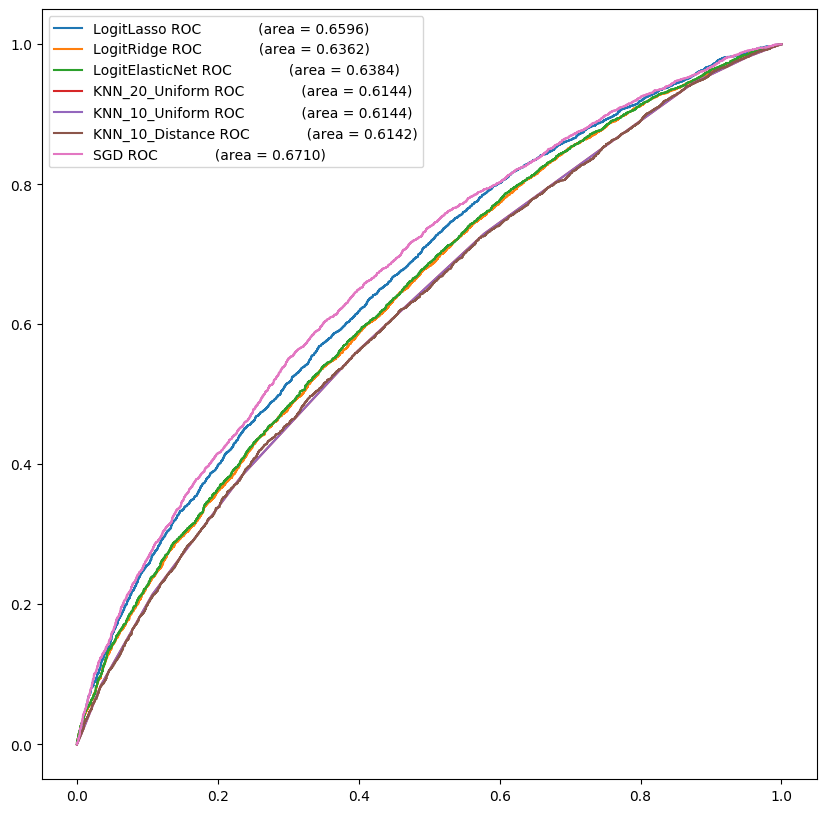

In [247]:
plt.figure(figsize = (10, 10))
for i in SCALED_ML_MODELS.keys():
    try:
        plt.plot(fpr_s[i], tpr_s[i], label = i + ' ROC \
            (area = %0.4f)' % auc_dict_s[i])
    except:
        pass
plt.legend()

## Unscaled classifiers
Based on percentage difference - use `random_state = 499` and `cv = 5` for everything

In [31]:
X2, Y2 = create_features(MLB_DF[MLB_DF.Y <= cutoff], True)

In [32]:
UNSCALED_ML_MODELS = {}

In [33]:
Lasso = LogisticRegressionCV(cv = 5, random_state = 499,
                               penalty='l1',
                               solver='saga',
                            max_iter = 400)
Lasso.fit(X2, Y2)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=400, multi_class='auto', n_jobs=None,
                     penalty='l1', random_state=499, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0)

In [34]:
Ridge = LogisticRegressionCV(Cs = [0.1], 
                             cv = 5, random_state = 499,
                               penalty='l2',
                               solver='saga',
                            max_iter = 400)
Ridge.fit(X2, Y2)

LogisticRegressionCV(Cs=[0.1], class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=400, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=499, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0)

In [35]:
ElasticNet = LogisticRegressionCV(Cs = [0.01], 
                                  cv = 5, random_state = 499,
                               penalty='elasticnet',
                               solver='saga',
                               l1_ratios = [0.5],
                                 max_iter = 400)
ElasticNet.fit(X2, Y2)

LogisticRegressionCV(Cs=[0.01], class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=[0.5],
                     max_iter=400, multi_class='auto', n_jobs=None,
                     penalty='elasticnet', random_state=499, refit=True,
                     scoring=None, solver='saga', tol=0.0001, verbose=0)

In [248]:
# # Stochastic gradient descent
# SGD = SGDClassifier(random_state = 499, 
#               n_iter_no_change = 10, loss='log')
# SGD.fit(X2, Y2)

In [37]:
# # Decision tree
# param_grid = {
#     'criterion': ('gini', 'entropy'),
#     'max_depth': [1, 2, 3, 4, 5, 7],
#     'max_features': ['auto', 'sqrt', 'log2', None],
#     'random_state': [499]
# }
# clf = GridSearchCV(DecisionTreeClassifier(), 
#              param_grid)
# clf.fit(X2, Y2)

In [38]:
# pd.DataFrame(clf.cv_results_).sort_values(
# by = 'rank_test_score').head(5)

In [39]:
DT = DecisionTreeClassifier(
    random_state = 499,
    criterion = 'entropy',
    max_depth = 3,
    max_features = None
)
DT.fit(X2, Y2)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=499, splitter='best')

In [40]:
# # RandomSearc for RandomForest
# param_grid = {
#     'n_estimators': [30, 40, 50, 60],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [2, 3, 4],
#     'max_features': ['auto'],
#     'oob_score': [True],
#     'random_state': [499]
# }
# clf_rf = RandomizedSearchCV(RandomForestClassifier(), 
#              param_grid, cv=5, n_jobs = -1)
# clf_rf.fit(X2, Y2)

In [41]:
# print("Optimal: ", clf_rf.best_params_)
# print("Score: ", clf_rf.best_score_)

In [42]:
# Random forest
RF = RandomForestClassifier(
    n_estimators = 60, 
    max_depth = 4, 
    max_features = 'auto',
    criterion = 'entropy',
    oob_score = True,
    random_state = 499)
RF.fit(X2, Y2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=True, random_state=499, verbose=0,
                       warm_start=False)

Computer the home bias

In [47]:
home_bias = (math.exp(Lasso.intercept_[0]))/(
    1 + math.exp(Lasso.intercept_[0]))
print(home_bias)

0.5459607381503085


In [48]:
xgb_model = XGBClassifier(base_score = home_bias,
                     random_state = 499,
                     n_jobs = -1)
# param_grid = {
#     'max_depth': [3, 5],
#     'learning_rate': [0.02, 0.05, 0.1, 0.15, 0.2, 0.24, 0.251],
#     'n_estimators': [15, 30, 50, 100, 200],
#     'subsample': [0.55, 0.62, 0.69, 0.76, 0.83, 0.89],
#     'cv': [5]
# }

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.001, 0.01, 0.025, 0.05, 0.08, 0.1, 0.15],
    'n_estimators': [50, 100, 200, 300, 400],
#     'subsample': [0.55, 0.62, 0.69, 0.76, 0.83, 0.89],
    'cv': [5]
}
rscv = RandomizedSearchCV(xgb_model, param_grid)
rscv.fit(X2, Y2)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5459607381503085,
                                           booster=None, colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_c...
                                           subsample=None, tree_method=None,
                                           validate_parameters=False,
                                           verbosity=None),
                 

In [49]:
# pd.DataFrame(rscv.cv_results_)

In [50]:
# XGBoost
XGBooster = XGBClassifier(base_score = home_bias,
            n_estimators = 15,
           max_depth = 3,
           learning_rate = 0.251,
           subsample = 0.89,                
             random_state = 499,
                     n_jobs = -1,
                          cv = 5)
XGBooster = XGBClassifier(base_score = home_bias,
            n_estimators = 300,
           max_depth = 3,
           learning_rate = 0.05,          
             random_state = 499,
                     n_jobs = -1,
                          cv = 5)
XGBooster.fit(X2, Y2)

XGBClassifier(base_score=0.5459607381503085, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, cv=5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=499, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [51]:
# Logit
UNSCALED_ML_MODELS['LogitLasso'] = Lasso
UNSCALED_ML_MODELS['LogitRidge'] = Ridge
UNSCALED_ML_MODELS['LogitElasticNet'] = ElasticNet

# SGD
# UNSCALED_ML_MODELS['SGD'] = SGD

# XGBoost
UNSCALED_ML_MODELS['XGBoost'] = XGBooster

# RF
UNSCALED_ML_MODELS['DecisionTree'] = DT

# RF
UNSCALED_ML_MODELS['RF'] = RF

Score our models and determine the output

In [260]:
UNSCALED_SCORE_DF = score_models(
    UNSCALED_ML_MODELS,
    UNSCALED_ML_RESULTS,
    MLB_FINAL_DATA_UNSCALED
)

In [264]:
UNSCALED_SCORE_DF.mean()

LogitLasso         0.623929
LogitRidge         0.624548
LogitElasticNet    0.624239
DecisionTree       0.616620
RF                 0.622077
SGD                0.588096
XGBoost            0.623105
dtype: float64

In [266]:
UNSCALED_SCORE_DF

,LogitLasso,LogitRidge,LogitElasticNet,DecisionTree,RF,SGD,XGBoost
Y,,,,,,,
2016,0.610218,0.615163,0.615575,0.599506,0.608158,0.583848,0.612279
2017,0.624691,0.623457,0.623457,0.612346,0.618107,0.583951,0.621399
2018,0.635653,0.635241,0.634417,0.632359,0.637299,0.596130,0.637299
2019,0.625155,0.624330,0.623505,0.622268,0.624742,0.588454,0.621443


In [55]:
UNSCALED_SCORE_DF.to_csv(PATH_TO_VIS_DATA + 'unscaled_model_scores.csv')

In [268]:
UNSCALED_BRIER_DF = brier_score_models(
    UNSCALED_ML_MODELS,
    UNSCALED_ML_RESULTS,
    MLB_FINAL_DATA_UNSCALED
)

In [269]:
UNSCALED_BRIER_DF.mean()

LogitLasso         0.226898
LogitRidge         0.227006
LogitElasticNet    0.226987
DecisionTree       0.230778
RF                 0.229027
SGD                0.338550
XGBoost            0.227464
dtype: float64

In [57]:
UNSCALED_BRIER_DF.T.min()

Y
2016    0.230139
2017    0.225927
2018    0.223842
2019    0.226871
dtype: float64

In [58]:
UNSCALED_BRIER_DF.std()

LogitLasso         0.002504
LogitRidge         0.002378
LogitElasticNet    0.002388
DecisionTree       0.003992
RF                 0.002729
SGD                0.006243
XGBoost            0.002864
dtype: float64

In [59]:
UNSCALED_BRIER_DF.to_csv(PATH_TO_VIS_DATA + 'unscaled_brier_scores.csv')

In [60]:
def score_models_monthly(MODELS_TO_TEST,
                 RESULTS_DF,
                 DATA_DF):
    # Score all models
    for i in MODELS_TO_TEST.keys():
        model = MODELS_TO_TEST[i]
        for month in RESULTS_DF.index:
            x_test = DATA_DF[month]['x']
            y_test = DATA_DF[month]['y']

            RESULTS_DF.loc[month, i] = model.score(
                x_test, y_test)
    
    return RESULTS_DF

In [61]:
MLB_MONTH_2019 = MLB_DF[MLB_DF.Y == 2019]
months = list(set(MLB_DF.M))
YEARLY_DATA = {}
for i in months:
    YEARLY_MLB = create_features(MLB_MONTH_2019[MLB_MONTH_2019.M == i])
    x = YEARLY_MLB[0]
    YEARLY_DATA[i] = {
        'x': x,
        'y': YEARLY_MLB[1]
    }

In [152]:
UNSCALED_SCORE_2019_DF = score_models_monthly(
    UNSCALED_ML_MODELS,
    UNSCALED_ML_RESULTS_MONTH,
    YEARLY_DATA
)

In [153]:
UNSCALED_SCORE_2019_DF.T.mean()

M
3    0.507937
4    0.594554
5    0.654300
6    0.616094
7    0.618267
8    0.608950
9    0.632653
dtype: float64

In [154]:
UNSCALED_SCORE_2019_DF.mean()

LogitLasso         0.616456
LogitRidge         0.615764
LogitElasticNet    0.614986
DecisionTree       0.595170
RF                 0.604405
SGD                0.582129
XGBoost            0.603844
dtype: float64

In [290]:
UNSCALED_SCORE_2019_DF[['LogitElasticNet', 'RF', 'XGBoost', 'Naive']].applymap(lambda x: round(x*1000)/10)

,LogitElasticNet,RF,XGBoost,Naive
M,,,,
3,55.6,46.3,48.1,63.0
4,60.1,60.6,58.5,50.9
5,65.3,66.3,65.3,53.6
6,61.5,63.0,61.5,52.9
7,63.1,61.5,62.0,50.3
8,61.9,61.9,62.4,55.9
9,63.0,63.5,64.8,52.3


In [156]:
UNSCALED_SCORE_2019_DF['Naive'] = MLB_DF[MLB_DF.Y == 2019].groupby(
'M')['outcome'].mean()

In [157]:
UNSCALED_SCORE_2019_DF.to_csv(PATH_TO_VIS_DATA + 'unscaled_model_monthly.csv')

In [527]:
UNSCALED_SCORE_2019_DF = pd.read_csv(PATH_TO_VIS_DATA + 'unscaled_model_monthly.csv')

In [528]:
UNSCALED_SCORE_2019_DF = UNSCALED_SCORE_2019_DF[1:]

In [530]:
UNSCALED_SCORE_2019_DF.set_index('M', inplace = True)

In [534]:
UNSCALED_SCORE_2019_DF

,LogitLasso,LogitRidge,LogitElasticNet,DecisionTree,RF,SGD,XGBoost,Naive
M,,,,,,,,
4,0.600522,0.600522,0.600522,0.592689,0.605744,0.577023,0.584856,0.509138
5,0.655340,0.650485,0.652913,0.677184,0.662621,0.628641,0.652913,0.536408
6,0.612903,0.615385,0.615385,0.622829,0.630273,0.600496,0.615385,0.528536
7,0.631148,0.636612,0.631148,0.612022,0.614754,0.581967,0.620219,0.502732
8,0.616867,0.621687,0.619277,0.626506,0.619277,0.534940,0.624096,0.559036
9,0.642857,0.630102,0.630102,0.627551,0.635204,0.614796,0.647959,0.522959


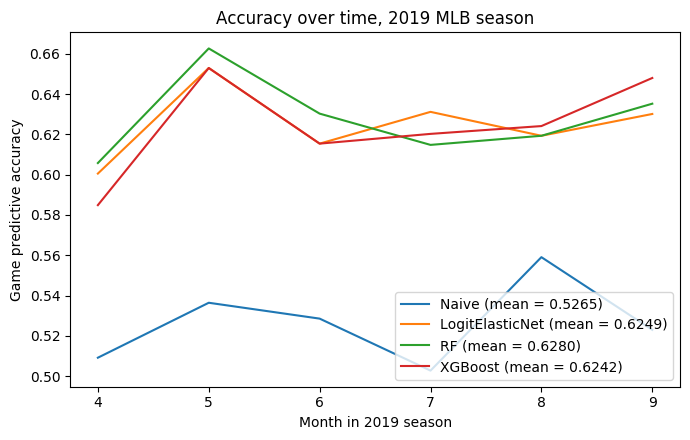

In [533]:
plt.figure(figsize = (7, 4.5))
for i in ['Naive', 'LogitElasticNet', 'RF', 'XGBoost']:
    plt.plot(UNSCALED_SCORE_2019_DF[i], label = i + \
             ' (mean = %0.4f)' % UNSCALED_SCORE_2019_DF.mean(
    )[i])
plt.xlabel('Month in 2019 season')
plt.ylabel('Game predictive accuracy')
plt.title('Accuracy over time, 2019 MLB season')
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.savefig('../charts/2019-model-comparison.png', dpi=320)

Evaluating ROC curves

In [183]:
X3, Y3 = create_features(MLB_DF[MLB_DF.Y > cutoff], True)

In [184]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
auc_dict = {}

for i in UNSCALED_ML_MODELS.keys():
    fpr[i], tpr[i], _ = roc_curve(
    Y3, [x[1] for x in UNSCALED_ML_MODELS[i].predict_proba(X3)])
    auc_dict[i] = auc(fpr[i], tpr[i])

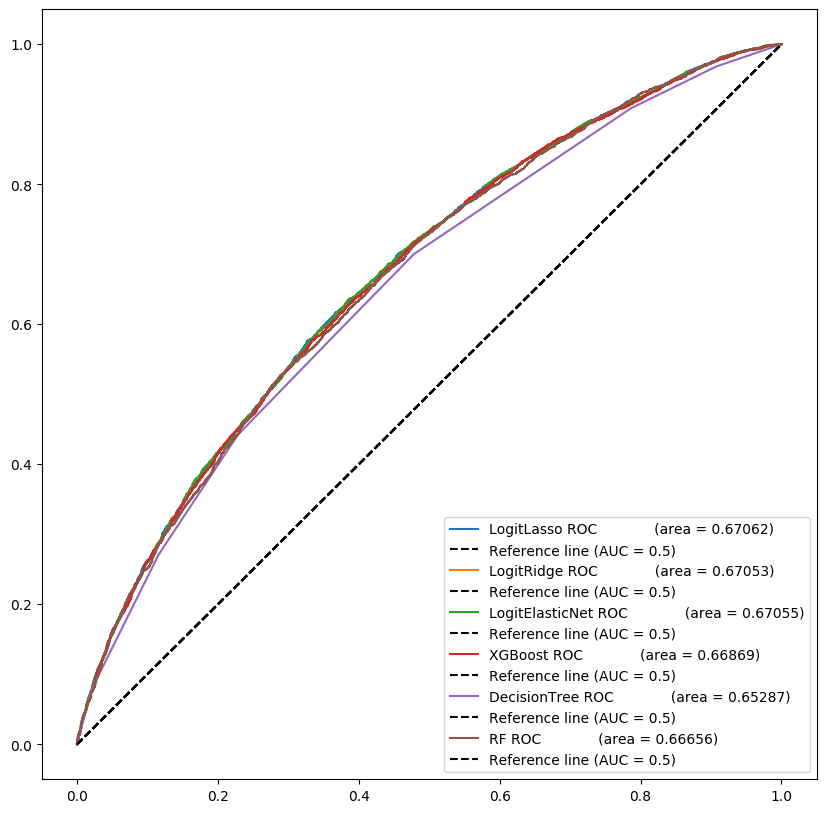

In [252]:
plt.figure(figsize = (10, 10))
for i in UNSCALED_ML_MODELS.keys():
    if ('SGD' not in i):
        plt.plot(fpr[i], tpr[i], label = i + ' ROC \
            (area = %0.5f)' % auc_dict[i])
plt.plot([0, 1], 'r--', color = 'black', label = 'Reference line (AUC = 0.5)')
plt.legend()

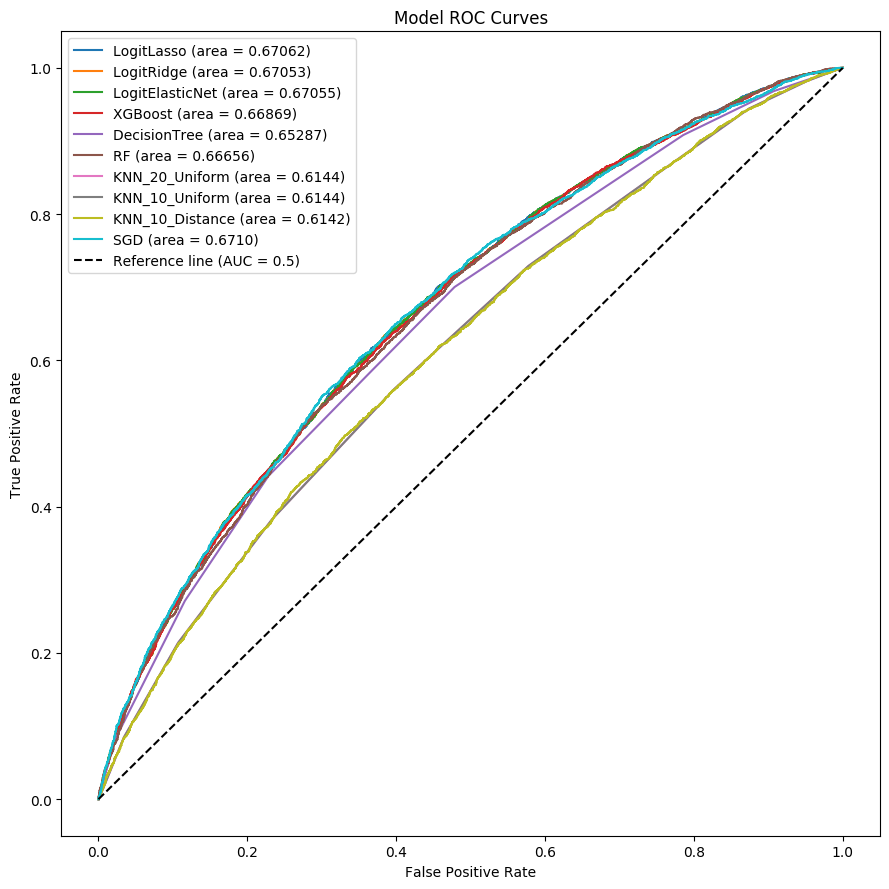

In [274]:
plt.figure(figsize = (9, 9))
for i in UNSCALED_ML_MODELS.keys():
    if ('SGD' not in i):
        plt.plot(fpr[i], tpr[i], label = i + ' (area = %0.5f)' % auc_dict[i])
for i in SCALED_ML_MODELS.keys():
    if ('Logit' not in i):
        try:
            plt.plot(fpr_s[i], tpr_s[i], label = i + ' (area = %0.4f)' % auc_dict_s[i])
        except:
            pass
plt.plot([0, 1], 'r--', color = 'black', label = 'Reference line (AUC = 0.5)')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model ROC Curves')
plt.tight_layout()
plt.savefig('../charts/model-full-roc.png', dpi=320)
plt.show()

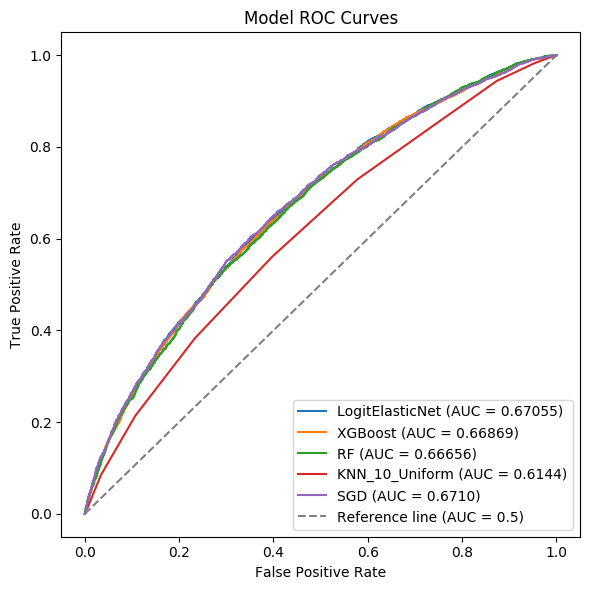

In [253]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.figure(figsize = (6, 6))
for i in ['LogitElasticNet', 'XGBoost', 'RF']:
    plt.plot(fpr[i], tpr[i], label = i + ' (AUC = %0.5f)' % auc_dict[i])
for i in ['KNN_10_Uniform', 'SGD']:
    if ('Logit' not in i):
        try:
            plt.plot(fpr_s[i], tpr_s[i], label = i + ' (AUC = %0.4f)' % auc_dict_s[i])
        except:
            pass
plt.plot([0, 1], 'r--', color = 'GRAY', label = 'Reference line (AUC = 0.5)')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model ROC Curves')
plt.tight_layout()
plt.savefig('../charts/model-abbreviated-roc.png', dpi=320)
plt.show()

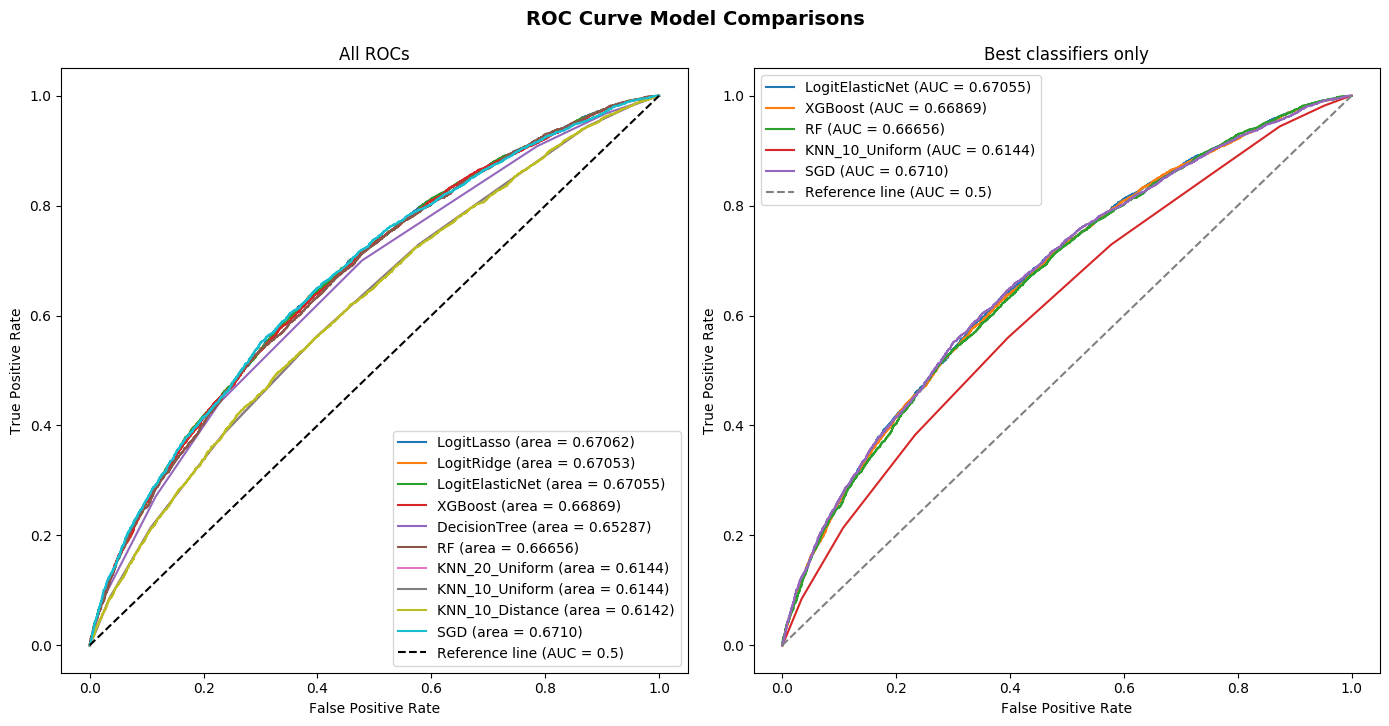

In [285]:
# PLOT BOTH AT ONCE

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 7))
fig.suptitle('ROC Curve Model Comparisons', y = 1.03, fontsize = 14, fontweight = 'bold')


import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
for i in UNSCALED_ML_MODELS.keys():
    if ('SGD' not in i):
        ax1.plot(fpr[i], tpr[i], label = i + ' (area = %0.5f)' % auc_dict[i])
for i in SCALED_ML_MODELS.keys():
    if ('Logit' not in i):
        try:
            ax1.plot(fpr_s[i], tpr_s[i], label = i + ' (area = %0.4f)' % auc_dict_s[i])
        except:
            pass
ax1.plot([0, 1], 'r--', color = 'black', label = 'Reference line (AUC = 0.5)')
ax1.legend()
ax1.set(xlabel = 'False Positive Rate', ylabel='True Positive Rate', title='All ROCs')
plt.tight_layout()


for i in ['LogitElasticNet', 'XGBoost', 'RF']:
    ax2.plot(fpr[i], tpr[i], label = i + ' (AUC = %0.5f)' % auc_dict[i])
for i in ['KNN_10_Uniform', 'SGD']:
    if ('Logit' not in i):
        try:
            ax2.plot(fpr_s[i], tpr_s[i], label = i + ' (AUC = %0.4f)' % auc_dict_s[i])
        except:
            pass
ax2.plot([0, 1], 'r--', color = 'GRAY', label = 'Reference line (AUC = 0.5)')
ax2.legend()
ax2.set(xlabel = 'False Positive Rate', ylabel='True Positive Rate', title='Best classifiers only')

plt.tight_layout()
plt.savefig('../charts/model-roc-double.png', dpi=320)
plt.show()

### Final model evaluation
Looking at ElasticNet, XGBoost, KNN, SVC_C1, Naive


Test over 2015 to 2019 modeling each season. Increased to 10 fold CV to combat overfitting

In [189]:
FINAL_MODELS = {}
# Models requiring scaling
FINAL_MODELS['KNN'] = KNeighborsClassifier(n_neighbors = 10, 
                    weights = 'uniform',
                    algorithm = 'auto')

FINAL_MODELS['SVC'] = SVC(random_state = 499,
               degree = 5, C = 0.01)

# Models not requiring scaling
FINAL_MODELS['ElasticNet'] = LogisticRegressionCV(Cs = [0.01], 
                                  cv = 10, random_state = 499,
                               penalty='elasticnet',
                               solver='saga',
                               l1_ratios = [0.5],
                                 max_iter = 1000)

# FINAL_MODELS['Lasso'] = LogisticRegressionCV(cv = 5, 
#                              random_state = 499,
#                                penalty='l1',
#                                solver='saga',
#                             max_iter = 4000)

FINAL_MODELS['RandomForest'] = RandomForestClassifier(
    n_estimators = 60, 
    max_depth = 4, 
    max_features = 'auto',
    criterion = 'entropy',
    oob_score = True,
    random_state = 499)

FINAL_MODELS['XGBoost'] = XGBClassifier(base_score = home_bias,
            n_estimators = 15,
           max_depth = 3,
           learning_rate = 0.251,
           subsample = 0.89,                
             random_state = 499,
                     n_jobs = -1,
                          cv = 10)

Create our response dataframes

In [190]:
MODELS_FINAL_TRAIN = pd.DataFrame([2016, 2017, 2018, 2019]).rename({
    0: 'Y'
}, axis = 1).set_index('Y')
MODELS_FINAL_TRAIN['SVC'] = 0
MODELS_FINAL_TRAIN['KNN'] = 0
MODELS_FINAL_TRAIN['ElasticNet'] = 0
MODELS_FINAL_TRAIN['RandomForest'] = 0
MODELS_FINAL_TRAIN['XGBoost'] = 0

In [191]:
MODELS_FINAL_TEST = MODELS_FINAL_TRAIN.copy()

Fit each year's data

In [192]:
# iterate over years
# , 2017, 2018, 2019
for year in [2016, 2017, 2018, 2019]:
    YEAR_MLB = MLB_DF[MLB_DF.Y == year]
    
    # Set PCT = True for non-scaled, PCT = False for scaled
    X, Y = create_features(YEAR_MLB, True)
    x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y)

    for i in ['ElasticNet', 'RandomForest', 'XGBoost']:
        model = FINAL_MODELS[i]
        model.fit(x_train, y_train)
        MODELS_FINAL_TRAIN.loc[year, i] = model.score(x_train, y_train)
        MODELS_FINAL_TEST.loc[year, i] = model.score(x_test, y_test)

In [193]:
MODELS_FINAL_TEST

,SVC,KNN,ElasticNet,RandomForest,XGBoost
Y,,,,,
2016,0,0,0.599671,0.578254,0.581549
2017,0,0,0.601974,0.606908,0.597039
2018,0,0,0.633224,0.639803,0.628289
2019,0,0,0.635914,0.634267,0.640857


In [194]:
# iterate over years
for year in [2016, 2017, 2018, 2019]:
    YEAR_MLB = MLB_DF[MLB_DF.Y == year]
    
    # Set PCT = True for non-scaled, PCT = False for scaled
    X, Y = create_features(YEAR_MLB, False)
    x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y)
    sclr = StandardScaler()
    x_train = sclr.fit_transform(x_train)
    x_test = sclr.transform(x_test)
    
    for i in ['KNN', 'SVC']:
        model = FINAL_MODELS[i]
        model.fit(x_train, y_train)
        MODELS_FINAL_TRAIN.loc[year, i] = model.score(x_train, y_train)
        MODELS_FINAL_TEST.loc[year, i] = model.score(x_test, y_test)

In [195]:
MODELS_FINAL_TRAIN

,SVC,KNN,ElasticNet,RandomForest,XGBoost
Y,,,,,
2016,0.533516,0.665385,0.618681,0.664286,0.685714
2017,0.541164,0.672887,0.643249,0.667947,0.692097
2018,0.535969,0.682043,0.640308,0.669962,0.682043
2019,0.534103,0.676568,0.628163,0.674917,0.685369


In [196]:
(MODELS_FINAL_TRAIN - MODELS_FINAL_TEST).mean()

SVC             0.001630
KNN             0.108385
ElasticNet      0.014905
RandomForest    0.054470
XGBoost         0.074372
dtype: float64

In [483]:
MODELS_FINAL_TEST.mean()

SVC             0.534558
KNN             0.565836
ElasticNet      0.617696
RandomForest    0.614808
XGBoost         0.611934
Naive           0.531560
dtype: float64

In [197]:
MODELS_FINAL_TRAIN['Naive'] = MLB_DF[MLB_DF.Y > 2015].groupby('Y')['outcome'].mean()
MODELS_FINAL_TEST['Naive'] = MLB_DF[MLB_DF.Y > 2015].groupby('Y')['outcome'].mean()

In [198]:
MODELS_FINAL_TRAIN

,SVC,KNN,ElasticNet,RandomForest,XGBoost,Naive
Y,,,,,,
2016,0.533516,0.665385,0.618681,0.664286,0.685714,0.529872
2017,0.541164,0.672887,0.643249,0.667947,0.692097,0.539506
2018,0.535969,0.682043,0.640308,0.669962,0.682043,0.527378
2019,0.534103,0.676568,0.628163,0.674917,0.685369,0.529485


In [486]:
MODELS_FINAL_TEST.mean()

SVC             0.534558
KNN             0.565836
ElasticNet      0.617696
RandomForest    0.614808
XGBoost         0.611934
Naive           0.531560
dtype: float64

In [200]:
MODELS_FINAL_TRAIN.to_csv(PATH_TO_VIS_DATA + 'final_model_train.csv')
MODELS_FINAL_TEST.to_csv(PATH_TO_VIS_DATA + 'final_model_test.csv')

In [201]:
# iterate over years
# , 2017, 2018, 2019
for year in [2016, 2017, 2018, 2019]:
    YEAR_MLB = MLB_DF[MLB_DF.Y == year]
    
    # Set PCT = True for non-scaled, PCT = False for scaled
    X, Y = create_features(YEAR_MLB, True)
    x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y)

    for i in ['ElasticNet', 'RandomForest', 'XGBoost']:
        model = FINAL_MODELS[i]
        model.fit(x_train, y_train)
        MODELS_FINAL_TRAIN.loc[year, i] = model.score(x_train, y_train)
        MODELS_FINAL_TEST.loc[year, i] = model.score(x_test, y_test)

In [202]:
BRIER_SCORES = pd.DataFrame([2016, 2017, 2018, 2019]).rename({
    0: 'Y'
}, axis = 1).set_index('Y')
BRIER_SCORES['ElasticNet'] = 0
BRIER_SCORES['RandomForest'] = 0
BRIER_SCORES['XGBoost'] = 0

In [203]:
BRIER_NAIVE = MLB_DF[MLB_DF.Y > 2015].groupby(['Y', 'outcome'])['outcome'].count().to_frame().rename({
    'outcome': 'count'
}, axis = 1).reset_index()
BRIER_NAIVE['difference'] = (BRIER_NAIVE['count'] - BRIER_NAIVE['count'] * BRIER_NAIVE['outcome'])
BRIER_NAIVE_SCORER = BRIER_NAIVE.groupby('Y').sum()
BRIER_NAIVE_SCORER['difference']/BRIER_NAIVE_SCORER['count']

Y
2016    0.470128
2017    0.460494
2018    0.472622
2019    0.470515
dtype: float64

In [204]:
BRIER_SCORES['Naive'] = BRIER_NAIVE_SCORER['difference']/BRIER_NAIVE_SCORER['count']

In [491]:
BRIER_SCORES

,ElasticNet,RandomForest,XGBoost,Naive
Y,,,,
2016,0.230803,0.235042,0.236653,0.470128
2017,0.233752,0.232582,0.233471,0.460494
2018,0.223714,0.222452,0.226820,0.472622
2019,0.222970,0.223184,0.223081,0.470515


In [206]:
# iterate over years
# , 2017, 2018, 2019
for year in [2016, 2017, 2018, 2019]:
    YEAR_MLB = MLB_DF[MLB_DF.Y == year]
    
    # Set PCT = True for non-scaled, PCT = False for scaled
    X, Y = create_features(YEAR_MLB, True)
    x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y)

    for i in ['ElasticNet', 'RandomForest', 'XGBoost']:
        model = FINAL_MODELS[i]
        model.fit(x_train, y_train)
        BRIER_SCORES.loc[year, i] =  brier_score_loss(y_test,
                    [x[1] for x in model.predict_proba(x_test)])

In [487]:
BRIER_SCORES.mean()

ElasticNet      0.227810
RandomForest    0.228315
XGBoost         0.230006
Naive           0.468440
dtype: float64

In [208]:
BRIER_SCORES.to_csv(PATH_TO_VIS_DATA + 'brier_scores.csv')

### Exploratory evaluation
Understanding our models

In [89]:
new_cols = ['OBP', 'WHIP', 'K9', 'HR9', 'K/BB', 'FIP', 'ISO', 'ELO', 'rest']

<BarContainer object of 9 artists>

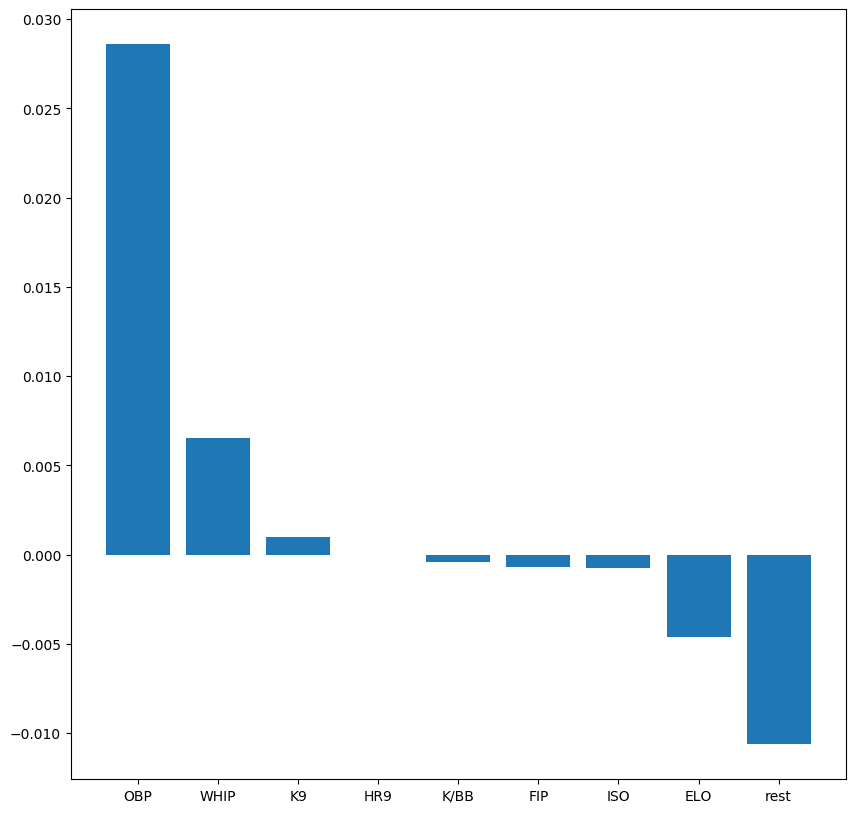

In [90]:
plt.figure(figsize = (10, 10))

plt.bar(new_cols, pd.Series(FINAL_MODELS['ElasticNet'].coef_[0], 
          index = x_train.columns).sort_values(
    ascending = False))

In [291]:
pd.Series(FINAL_MODELS['ElasticNet'].coef_[0], 
          index = x_train.columns)

OBP_difference_PCT     0.028587
WHIP_difference_PCT   -0.004617
K9_difference_PCT      0.000997
HR9_difference_PCT    -0.000691
K/BB_difference_PCT   -0.000753
FIP_difference_PCT    -0.000410
ISO_difference_PCT     0.006530
ELO_difference_PCT     0.000000
rest_difference       -0.010631
dtype: float64

In [334]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.genmod.generalized_linear_model import GLM

In [333]:
x_train.columns

Index(['OBP_difference_PCT', 'WHIP_difference_PCT', 'K9_difference_PCT',
       'HR9_difference_PCT', 'K/BB_difference_PCT', 'FIP_difference_PCT',
       'ISO_difference_PCT', 'ELO_difference_PCT', 'rest_difference'],
      dtype='object')

In [394]:
X2_train = X2.drop(labels = ['HR9_difference_PCT',
                            'rest_difference', 
                            'K9_difference_PCT'], axis = 1)

In [412]:
Logit(Y2, X2).fit_regularized(alpha = 0.5,
                            ).summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6510111130764158
            Iterations: 53
            Function evaluations: 69
            Gradient evaluations: 53


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 9 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:                36417
Model:                          Logit   Df Residuals:                    36408
Method:                           MLE   Df Model:                            8
Date:                Sun, 26 Apr 2020   Pseudo R-squ.:                 0.05630
Time:                        01:27:45   Log-Likelihood:                -23708.
converged:                       True   LL-Null:                       -25122.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
OBP_difference_PCT      0.0347      0.001     37.591      0.000       0.033       0.036
WHIP_difference_PCT    -0.0059      0.001     -4.809      0.000      -0.008      -0.003
K9_difference_PCT       0.0012      0.000      2.495      0.013       0.000       0.002
HR9_difference_PCT      0.0003      0.000      0.738      0.461      -0.001       0.001
K/BB_difference_PCT    -0.0016      0.000     -5.329      0.000      -0.002      -0.001
FIP_difference_PCT     -0.0069      0.001     -4.806      0.000      -0.010      -0.004
ISO_difference_PCT      0.0039      0.000     14.235      0.000       0.003       0.004
ELO_difference_PCT     -0.0112      0.004     -2.892      0.004      -0.019      -0.004
rest_difference         0.0042      0.005      0.853      0.394      -0.005       0.014
=======================================================================================
"""

In [91]:
LOGIT_FI = abs(pd.Series(FINAL_MODELS['ElasticNet'].coef_[0], 
          index = new_cols)).sort_values(
ascending = False)

In [92]:
# XGBoost feature importance
XGB_FEATURES = pd.Series(FINAL_MODELS['XGBoost'].get_booster(
).get_score(
    importance_type = 'total_gain')).sort_values(
    ascending = False)
XGB_FEATURES.index = [i for i in new_cols if i != 'rest']

XGB_COLS = [i[0:4] for i in list(XGB_FEATURES.index)]

<BarContainer object of 8 artists>

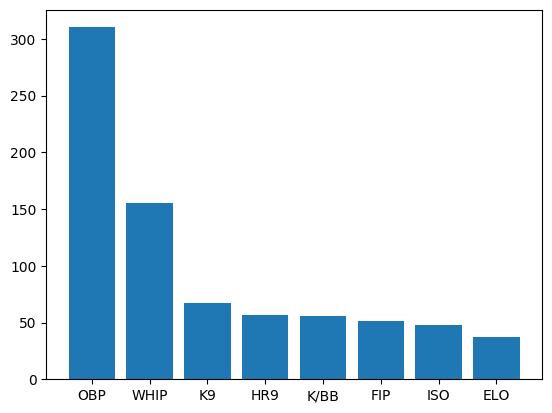

In [93]:
plt.bar(XGB_COLS,
        XGB_FEATURES)

In [94]:
XGB_FEATURES

OBP     310.257003
WHIP    155.038275
K9       67.590028
HR9      56.259286
K/BB     55.664155
FIP      51.510812
ISO      47.604990
ELO      37.500933
dtype: float64

In [95]:
XGB_FI = pd.Series(FINAL_MODELS['XGBoost'].feature_importances_,
          new_cols).sort_values(ascending = False)

In [96]:
RF_FI = pd.Series(FINAL_MODELS['RandomForest'].feature_importances_,
          new_cols).sort_values(ascending = False)

In [97]:
FI_df = pd.DataFrame([LOGIT_FI, XGB_FI, RF_FI], index = [
    'ElasticNet', 'XGBoost', 'RandomForest'
]).T

In [98]:
FI_df

,ElasticNet,XGBoost,RandomForest
OBP,0.028587,0.260707,0.334458
rest,0.010631,0.000000,0.001511
ISO,0.006530,0.160931,0.248600
WHIP,0.004617,0.082719,0.074011
K9,0.000997,0.105006,0.042547
K/BB,0.000753,0.079514,0.072443
HR9,0.000691,0.099276,0.054707
FIP,0.000410,0.098226,0.057671
ELO,0.000000,0.113621,0.114053


In [99]:
FI_df.to_csv(PATH_TO_VIS_DATA + 'feature_importance.csv')

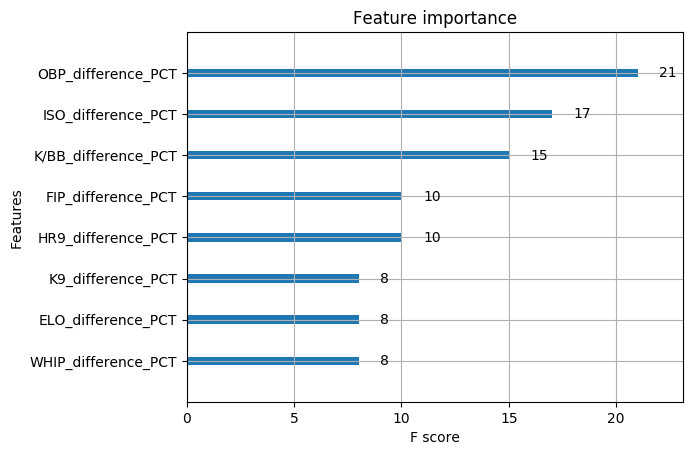

In [439]:
import xgboost
xgboost.plot_importance(FINAL_MODELS['XGBoost'])

In [100]:
from plotnine import *

Feature importance

In [420]:
import matplotlib.pyplot as plt

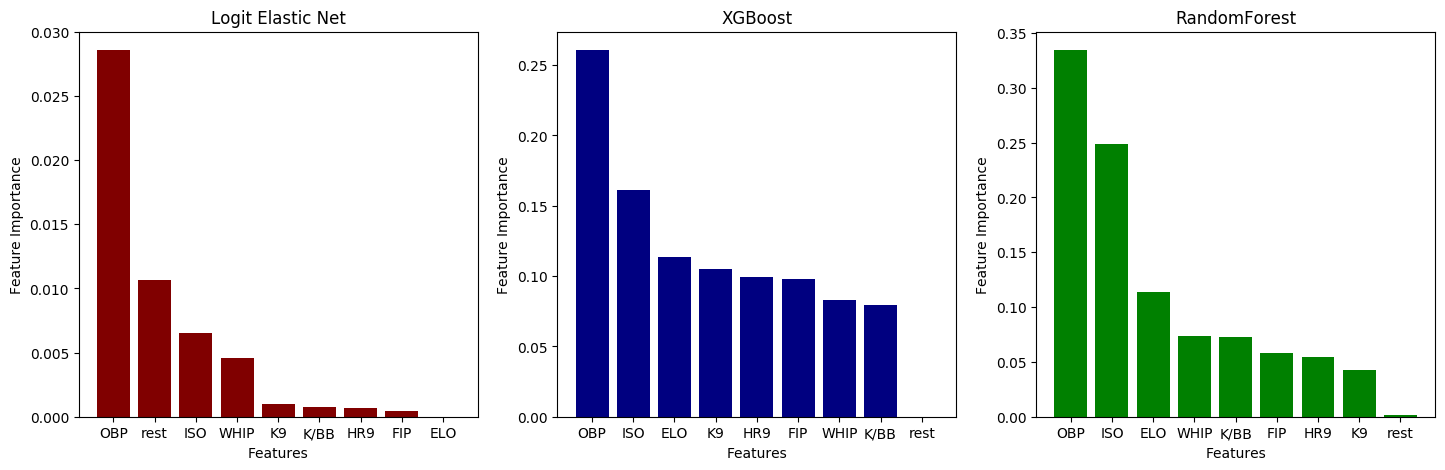

In [435]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (17.5, 5))

ELN = FI_df['ElasticNet'].sort_values(ascending = False)
XGB = FI_df['XGBoost'].sort_values(ascending = False)
RFN = FI_df['RandomForest'].sort_values(ascending = False)

ax1.bar(ELN.index, ELN, color = 'maroon')
ax1.set(xlabel = 'Features', 
        ylabel='Feature Importance', title='Logit Elastic Net')

ax2.bar(XGB.index, XGB, color = 'navy')
ax2.set(xlabel = 'Features', 
        ylabel='Feature Importance', title='XGBoost')

ax3.bar(RFN.index, RFN, color = 'green')
ax3.set(xlabel = 'Features', 
        ylabel='Feature Importance', title='RandomForest')

plt.savefig('../charts/feature-importances.png', dpi=320)

### Lift charts

In [464]:
x_test_lift = create_features(MLB_DF[MLB_DF.Y > 2015], True)[0]
y_test_lift = create_features(MLB_DF[MLB_DF.Y > 2015], True)[1]

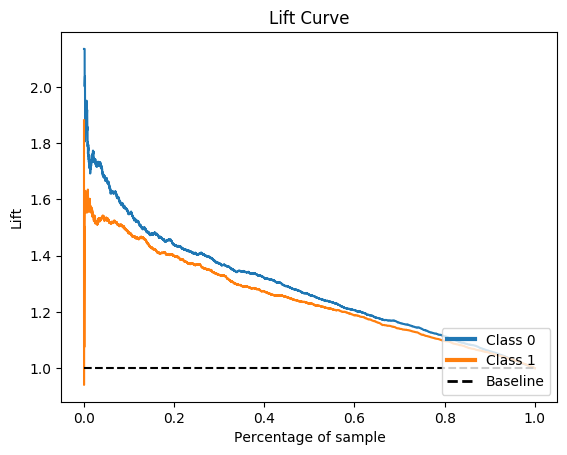

In [503]:
from scikitplot.metrics import plot_lift_curve

ax = plot_lift_curve(y_test_lift, 
                list(FINAL_MODELS['ElasticNet'].predict_proba(x_test_lift)))
ax.grid(False)

for l in ax.lines:
    l.set_lw(1.5)
    
plt.savefig('../charts/post-2015-lift.png', dpi=320)

In [507]:
# ONLY RUN ONCE

BRIER_TRUNCATED = BRIER_SCORES.copy()
# iterate over years
# , 2017, 2018, 2019
for year in [2016, 2017, 2018, 2019]:
    YEAR_MLB = MLB_DF[MLB_DF.Y == year]
    
    # Set PCT = True for non-scaled, PCT = False for scaled
    X, Y = create_features(YEAR_MLB, True)
    x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y)

    for i in ['ElasticNet', 'RandomForest', 'XGBoost']:
        model = FINAL_MODELS[i]
        model.fit(x_train, y_train)
        BRIER_TRUNCATED.loc[year, i] =  brier_score_loss(y_test,
                    [min(max(x[1], 0.15), 0.75) for x in model.predict_proba(x_test)])

In [508]:
BRIER_TRUNCATED.mean()

ElasticNet      0.227428
RandomForest    0.228384
XGBoost         0.229724
Naive           0.468440
dtype: float64

In [509]:
Lift_DF = pd.DataFrame([x[1] for x in FINAL_MODELS['RandomForest'].predict_proba(x_test)]).rename({
    0: 'RandomForest'
}, axis = 1)
Lift_DF = pd.concat([Lift_DF, pd.DataFrame([x[1] for x in FINAL_MODELS['XGBoost'].predict_proba(x_test)]).rename({
    0: 'XGBoost'
}, axis = 1),pd.DataFrame([x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(x_test)]).rename({
    0: 'ElasticNet'
}, axis = 1)], axis = 1)
Lift_DF['y'] = y_test.reset_index(drop = True)

In [510]:
def lift_bucketing(x):
    if (x <= 0.15):
        return 0.15
    if (x >= 0.75):
        return 0.75
    return x
    
Lift_DF_bucket = Lift_DF.applymap(lambda x: lift_bucketing(round(16*x)/16))

In [511]:
Lift_DF_bucket.groupby('ElasticNet').count()

,RandomForest,XGBoost,y
ElasticNet,,,
0.1500,15,15,15
0.1875,23,23,23
0.2500,37,37,37
0.3125,49,49,49
0.3750,46,46,46
0.4375,71,71,71
0.5000,83,83,83
0.5625,83,83,83
0.6250,82,82,82


In [512]:
Lift_Chart = pd.concat([
    Lift_DF_bucket.groupby('ElasticNet')['y'].mean().to_frame().rename({'y': 'ElasticNet'}, axis = 1),
    Lift_DF_bucket.groupby('RandomForest')['y'].mean().to_frame().rename(
        {'y': 'RandomForest'}, axis = 1),
    Lift_DF_bucket.groupby('XGBoost')['y'].mean().to_frame().rename({
        'y': 'XGBoost'}, axis = 1)], axis = 1).fillna(0)

In [513]:
Lift_Chart

,ElasticNet,RandomForest,XGBoost
0.1500,0.310000,0.000000,0.150000
0.1875,0.176087,0.000000,0.407143
0.2500,0.344595,0.305556,0.257692
0.3125,0.370408,0.300000,0.331579
0.3750,0.384783,0.376230,0.410377
0.4375,0.445775,0.430000,0.426000
0.5000,0.431928,0.426190,0.461111
0.5625,0.518675,0.486449,0.479032
0.6250,0.530488,0.527143,0.525904
0.6875,0.600000,0.628378,0.559091


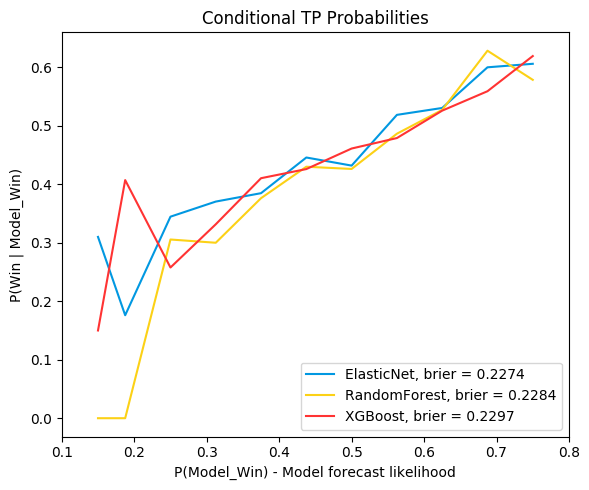

In [506]:
plt.figure(figsize = (6, 5))
plt.plot(Lift_Chart['ElasticNet'], color = '#0198E1',
         label = 'ElasticNet, brier = %0.4f' % BRIER_TRUNCATED.mean()['ElasticNet'])
plt.plot(Lift_Chart['RandomForest'], color = '#FCD116',
         label = 'RandomForest, brier = %0.4f' % BRIER_TRUNCATED.mean()['RandomForest'])
plt.plot(Lift_Chart['XGBoost'], color = '#FF3333',
         label = 'XGBoost, brier = %0.4f' % BRIER_TRUNCATED.mean()['XGBoost'])
plt.xlim(0.1, 0.8)
plt.xlabel('P(Model_Win) - Model forecast likelihood')
plt.ylabel('P(Win | Model_Win)')
plt.title('Conditional TP Probabilities')
plt.tight_layout()
plt.legend(loc = 'lower right')
plt.savefig('../charts/lift-final-truncated.png', dpi=320)

### Summative analysis

In [109]:
nationals_df = MLB_DF[(MLB_DF.Y == 2019) & ((MLB_DF.home_team == 'WAS') | (MLB_DF.away_team == 'WAS'))]

In [110]:
nats_features = create_features(nationals_df, True)

In [111]:
nats_home_indicator = (nationals_df.home_team == 'WAS').astype(int).reset_index(drop = True)

In [112]:
nats_predictions = [x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(nats_features[0])]
# (FINAL_MODELS['ElasticNet'].predict(nats_features[0]) == nats_features[1]).mean()

In [113]:
nats_wins = 0

nats_win_probabilities = []
for i in range(162):
    if (nats_home_indicator[i] == 1):
        if (nats_predictions[i] > 0.5):
            nats_wins = nats_wins + 1
        nats_win_probabilities.append(nats_predictions[i] - 0.5)
    else:
        if (nats_predictions[i] <= 0.5):
            nats_wins = nats_wins + 1
        nats_win_probabilities.append(1 - nats_predictions[i] - 0.5)


In [114]:
nats_wins

113

(0.0, 162.0, -0.4629822061792251, 0.5345642159056789)

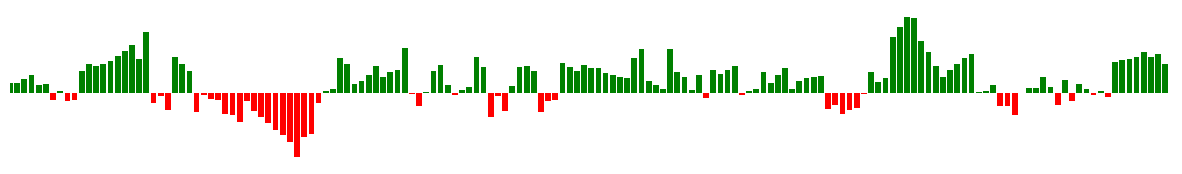

In [115]:
plt.figure(figsize = (15, 2))
plt.bar(range(162), nats_win_probabilities, color = ['green' if x > 0 else 'red' for x in nats_win_probabilities])
plt.xlim(0, 162)
plt.savefig('../charts/2019-washington-nationals.png', dpi=320)
plt.axis('off')

For my Yankees...

In [542]:
yanks = MLB_DF[(MLB_DF.Y == 2017) & ((MLB_DF.home_team == 'NYA') | (MLB_DF.away_team == 'NYA'))]
baby_bombers = create_features(yanks, True)
cradle = (yanks.home_team == 'NYA').astype(int).reset_index(drop = True)
yanks_2017 = [x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(baby_bombers[0])]

yankees_win = 0
nyy_win_probabilities = []
for i in range(162):
    if (cradle[i] == 1):
        if (yanks_2017[i] > 0.5):
            yankees_win = yankees_win + 1
        nyy_win_probabilities.append(yanks_2017[i] - 0.5)
    else:
        if (yanks_2017[i] <= 0.5):
            yankees_win = yankees_win + 1
        nyy_win_probabilities.append(1 - yanks_2017[i] - 0.5)
        
print(yankees_win)

99


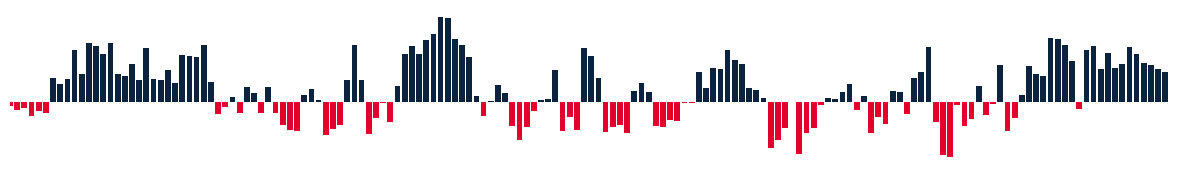

In [543]:
plt.figure(figsize = (15, 2))
plt.bar(range(162), nyy_win_probabilities, color = ['#0C2340' if x > 0 else '#E4002C' for x in nyy_win_probabilities])
plt.xlim(0, 162)
plt.axis('off')
plt.savefig('../charts/2017-newyork-yankees.png', dpi=320)

And the unfortunate but well deserved Red Sox (Dr. Jensen's team...)

In [118]:
Boston_Data = MLB_DF[(MLB_DF.Y == 2018) & ((MLB_DF.home_team == 'BOS') | (MLB_DF.away_team == 'BOS'))]
BOS_FEATURES = create_features(Boston_Data, True)
BOS_HOME = (Boston_Data.home_team == 'BOS').astype(int).reset_index(drop = True)
BOS_2018 = [x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(BOS_FEATURES[0])]

BOS_WIN = 0
bos_win_probabilities = []
for i in range(162):
    if (BOS_HOME[i] == 1):
        if (BOS_2018[i] > 0.5):
            BOS_WIN = BOS_WIN + 1
        bos_win_probabilities.append(BOS_2018[i] - 0.5)
    else:
        if (BOS_2018[i] <= 0.5):
            BOS_WIN = BOS_WIN + 1
        bos_win_probabilities.append(1 - BOS_2018[i] - 0.5)
        
print(BOS_WIN)

116


(0.0, 162.0, -0.4505295270169946, 0.4766515403127877)

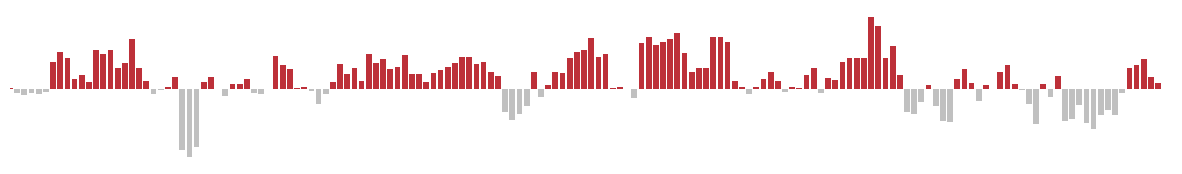

In [119]:
plt.figure(figsize = (15, 2))
plt.bar(range(162), bos_win_probabilities, color = ['#BD3039' if x > 0 else 'silver' for x in bos_win_probabilities])
plt.xlim(0, 162)
plt.savefig('../charts/2018-boston-redsox.png', dpi=320)
plt.axis('off')

Cleveland Indians

108


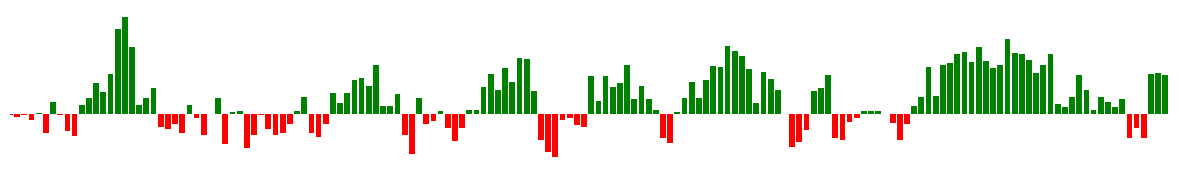

In [120]:
Boston_Data = MLB_DF[(MLB_DF.Y == 2017) & ((MLB_DF.home_team == 'CLE') | (MLB_DF.away_team == 'CLE'))]
BOS_FEATURES = create_features(Boston_Data, True)
BOS_HOME = (Boston_Data.home_team == 'CLE').astype(int).reset_index(drop = True)
BOS_2018 = [x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(BOS_FEATURES[0])]

BOS_WIN = 0
bos_win_probabilities = []
for i in range(162):
    if (BOS_HOME[i] == 1):
        if (BOS_2018[i] > 0.5):
            BOS_WIN = BOS_WIN + 1
        bos_win_probabilities.append(BOS_2018[i] - 0.5)
    else:
        if (BOS_2018[i] <= 0.5):
            BOS_WIN = BOS_WIN + 1
        bos_win_probabilities.append(1 - BOS_2018[i] - 0.5)
        
print(BOS_WIN)
plt.figure(figsize = (15, 2))
plt.bar(range(162), bos_win_probabilities, color = ['green' if x > 0 else 'red' for x in bos_win_probabilities])
plt.xlim(0, 162)
plt.axis('off')
plt.xlabel('Cleveland Indians, 2017')
plt.savefig('../charts/2017-cleveland-indians.png', dpi=320)


104


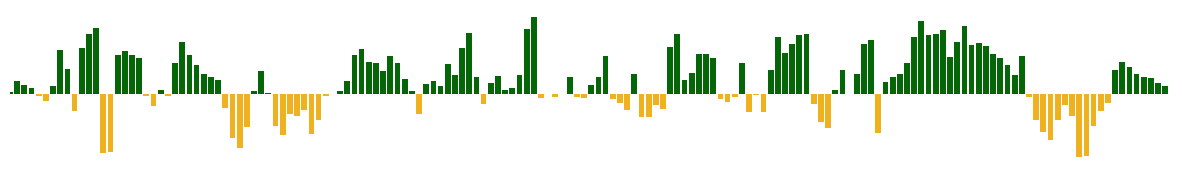

In [121]:
# OAKLAND A'S
Boston_Data = MLB_DF[(MLB_DF.Y == 2002) & ((MLB_DF.home_team == 'OAK') | (MLB_DF.away_team == 'OAK'))]
BOS_FEATURES = create_features(Boston_Data, True)
BOS_HOME = (Boston_Data.home_team == 'OAK').astype(int).reset_index(drop = True)
BOS_2018 = [x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(BOS_FEATURES[0])]

BOS_WIN = 0
bos_win_probabilities = []
for i in range(162):
    if (BOS_HOME[i] == 1):
        if (BOS_2018[i] > 0.5):
            BOS_WIN = BOS_WIN + 1
        bos_win_probabilities.append(BOS_2018[i] - 0.5)
    else:
        if (BOS_2018[i] <= 0.5):
            BOS_WIN = BOS_WIN + 1
        bos_win_probabilities.append(1 - BOS_2018[i] - 0.5)
        
print(BOS_WIN)
plt.figure(figsize = (15, 2))
plt.bar(range(162), bos_win_probabilities, color = ['#056607' if x > 0 else '#EFB21E' for x in bos_win_probabilities])
plt.xlim(0, 162)
plt.axis('off')
plt.xlabel('Oakland As, 2002 - Moneyball')
plt.savefig('../charts/2002-oakland-as.png', dpi=320)


### Analysis of the 2019 season to compare to Pythagorean

In [122]:
team_records = pd.DataFrame(list(set(MLB_DF.home_team))).rename(
    {0: 'team'}, axis = 1
).set_index('team')
team_records[2019] = 0

In [123]:
for team in list(set(MLB_DF.home_team)):
    TEAM_DATA = MLB_DF[(MLB_DF.Y == 2019) & ((MLB_DF.home_team == team) | (MLB_DF.away_team == team))]
    FEATURES = create_features(TEAM_DATA, True)
    HOME_TEAM = (TEAM_DATA.home_team == team).astype(int).reset_index(drop = True)
    TEAM_2019 = [x[1] for x in FINAL_MODELS['ElasticNet'].predict_proba(FEATURES[0])]

    WIN = 0
    for i in range(162):
        try:
            if (HOME_TEAM[i] == 1):
                if (TEAM_2019[i] > 0.5):
                    WIN = WIN + 1
            else:
                if (TEAM_2019[i] <= 0.5):
                    WIN = WIN + 1
        except:
            pass
    team_records.loc[team, 2019] = WIN
    print(team + ' ' + str(WIN))

MIA 26
TBA 107
KCA 41
HOU 131
WAS 113
ARI 79
SLN 75
TOR 57
ATL 106
MIL 75
NYA 115
SDN 63
CHA 54
COL 77
LAN 128
OAK 97
BOS 109
NYN 97
DET 33
SEA 65
BAL 36
MIN 106
CHN 99
SFN 62
CLE 103
PHI 81
TEX 73
ANA 78
CIN 76
PIT 63


In [124]:
actual_records = pd.read_csv(
    PATH_TO_OUTPUT_DATA + 'EDA/W_L_DATA.csv')
actual_records = actual_records[actual_records.Y == 2019]
actual_res = actual_records.sort_values(
    by = "W",ascending = False)[['team', 'W']].set_index('team')
actual_res = actual_res.reset_index(
).reset_index().set_index('team')
actual_res['actual_rank'] = actual_res['index'] + 1

In [125]:
pred_records = team_records.sort_values(
    by = 2019,ascending = False).reset_index(
).reset_index().set_index('team')
pred_records['pred_rank'] = pred_records['index'] + 1

In [126]:
comparison = pd.concat([
    pred_records,
    actual_res], axis = 1)[[2019, 'W', 
                            'pred_rank', 'actual_rank']]
comparison.rename({
    2019: 'pred_win',
    'W': 'actual_win'
}, axis = 1, inplace = True)
comparison = comparison.sort_values(
    by = 'actual_win', ascending = False)
comparison.to_csv(PATH_TO_VIS_DATA + 'WL_comparison.csv')
comparison

<ipython-input-126-09238f184377>:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  comparison = pd.concat([


,pred_win,actual_win,pred_rank,actual_rank
HOU,131,107,1,1
LAN,128,106,2,2
NYA,115,103,3,3
MIN,106,101,7,4
ATL,106,97,8,5
TBA,107,96,6,6
OAK,97,96,12,7
WAS,113,93,4,8
CLE,103,93,9,9
SLN,75,90,19,10


In [127]:
comparison['SqErr'] = (
    comparison['pred_win'] -
    comparison['actual_win']
)**2

In [128]:
MSE = sum(comparison['SqErr'])/30
MSE

200.73333333333332

In [129]:
import numpy as np
np.sqrt(MSE)

14.168039149202452